In [1]:
# importing useful packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
import math
from scipy.optimize import curve_fit
from scipy import odr as odr
import seaborn as sns
#sns.set(color_codes=True)
plt.style.use('seaborn-white')

_______________________________________________________________________________________
---------------------------------------------------

## Writing out WISE W1 magnitude errors

### Columns of 'wiseScosSvm':

'wiseX', 'wiseID', 'scosID', 'cx', 'cy', 'cz', 'htmID', 'ra', 'dec',
'ebv', 'w1mCorr', 'w1mCorrErr', 'w2mCorr', 'w2mCorrErr', 'bCalCorr',
'bCalCorrErr', 'rCalCorr', 'rCalCorrErr', 'zPhoto_ANN', 'zPhoto_Corr',
'fromAllSky', 'SVMClass', 'probGal', 'probStar', 'probQso',
'inPhotozCat'

In [2]:
wxs = pd.read_csv( 'wiseScosSvm.csv', usecols = [ 'wiseX', 'w1mCorr', 'w1mCorrErr', 'fromAllSky' ], 
                    header = 0, low_memory = False ) 
wxs.head()

,wiseX,w1mCorr,w1mCorrErr,fromAllSky
0,J113821.86-492730.2,15.578,0.044,0
1,J113829.99-492503.1,15.403,0.037,0
2,J113821.16-492311.9,15.139,0.036,0
3,J113817.76-491634.5,15.690,0.039,0
4,J113823.10-492513.8,15.381,0.038,0


In [4]:
u, c = np.unique( wxs.wiseX.values.astype(str), return_counts=True )

In [5]:
(c > 1).sum()

24675

In [8]:
u_in_both = u[c > 1]
u_in_both

array(['   J000001.73+495323.0', '   J000005.62+424302.4',
       '   J000006.86+300905.2', ..., '   J235928.19+331357.9',
       '   J235934.87+452849.2', '   J235946.36+190450.6'], dtype='<U22')

In [11]:
id_to_int = dict( zip( wxs.wiseX.values.astype(str), np.arange(wxs.shape[0]) ) )

In [3]:
wxs_0 = wxs[ wxs.fromAllSky.values == 0 ]
wxs_1 = wxs[ wxs.fromAllSky.values == 1 ]

In [6]:
wxs_0.head()

,wiseX,w1mCorr,w1mCorrErr,fromAllSky
0,J113821.86-492730.2,15.578,0.044,0
1,J113829.99-492503.1,15.403,0.037,0
2,J113821.16-492311.9,15.139,0.036,0
3,J113817.76-491634.5,15.690,0.039,0
4,J113823.10-492513.8,15.381,0.038,0


In [7]:
wxs_1.head()

,wiseX,w1mCorr,w1mCorrErr,fromAllSky
8784,J001131.72-765250.5,15.530,0.047,1
8785,J001112.04-770308.2,15.555,0.045,1
8786,J001112.07-765238.7,15.457,0.044,1
8787,J001036.20-765346.5,15.724,0.048,1
8788,J001057.10-764933.7,15.557,0.045,1


In [13]:
wxs_0['id'] = [ id_to_int[i] for i in wxs_0.wiseX.values ]

/home/marika/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [14]:
wxs_1['id'] = [ id_to_int[i] for i in wxs_1.wiseX.values ]

/home/marika/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [16]:
wxs_0.shape, wxs_1.shape

((38374666, 5), (1441454, 5))

In [28]:
list(wxs)

['wiseX', 'w1mCorr', 'w1mCorrErr', 'fromAllSky']

In [32]:
wxs_new = pd.DataFrame( np.concatenate( ( wxs_0.values[:,:-1], wxs_1[ ~np.in1d( wxs_1.id.values, wxs_0.id.values) ].values[:,:-1] ), axis=0 ), 
              columns=['wiseX', 'w1mCorr', 'w1mCorrErr', 'fromAllSky'])
wxs_new.head()

,wiseX,w1mCorr,w1mCorrErr,fromAllSky
0,J113821.86-492730.2,15.578,0.044,0
1,J113829.99-492503.1,15.403,0.037,0
2,J113821.16-492311.9,15.139,0.036,0
3,J113817.76-491634.5,15.69,0.039,0
4,J113823.10-492513.8,15.381,0.038,0


In [33]:
# write out data
f_out = 'wise_w1err.txt'
wxs_new.to_csv( f_out, sep = '\t', mode = 'w', header = True, index = False )

---------------------------------------------------
_______________________________________________________________________________________

### Merging the two dataframe

In [5]:
w1err_frame = pd.read_csv( 'wise_w1err.txt', delimiter = '\t' )
w1err_frame.head()

,wiseX,w1mCorr,w1mCorrErr
0,J113821.86-492730.2,15.578,0.044
1,J113829.99-492503.1,15.403,0.037
2,J113821.16-492311.9,15.139,0.036
3,J113817.76-491634.5,15.690,0.039
4,J113823.10-492513.8,15.381,0.038


In [6]:
w1err_frame['wiseX'] = [ i.strip() for i in w1err_frame.wiseX.values ]

In [7]:
w1err_frame.wiseX.values[0]

'J113821.86-492730.2'

In [8]:
np.mean( w1err_frame.w1mCorrErr ), np.max( w1err_frame.w1mCorrErr ), np.min( w1err_frame.w1mCorrErr )

(0.04362310395864908, 0.5379999999999999, 0.012)

In [9]:
np.median( w1err_frame.w1mCorrErr)

0.038

In [22]:
def hist_form():
    fig = plt.figure( figsize = (18, 12), dpi = 100 )
    plt.xlabel( '$\Delta m$ [mag]', fontsize = 47 )
    plt.ylabel( 'Frequency', fontsize = 47 )
    #plt.xscale('log')
    #plt.yscale('log')
    #plt.ylim([1e-1, 1e8])
    plt.xticks( fontsize = 43 )
    plt.yticks( fontsize = 43 )
    plt.tick_params( length=10, direction = 'inout', pad = 5 )

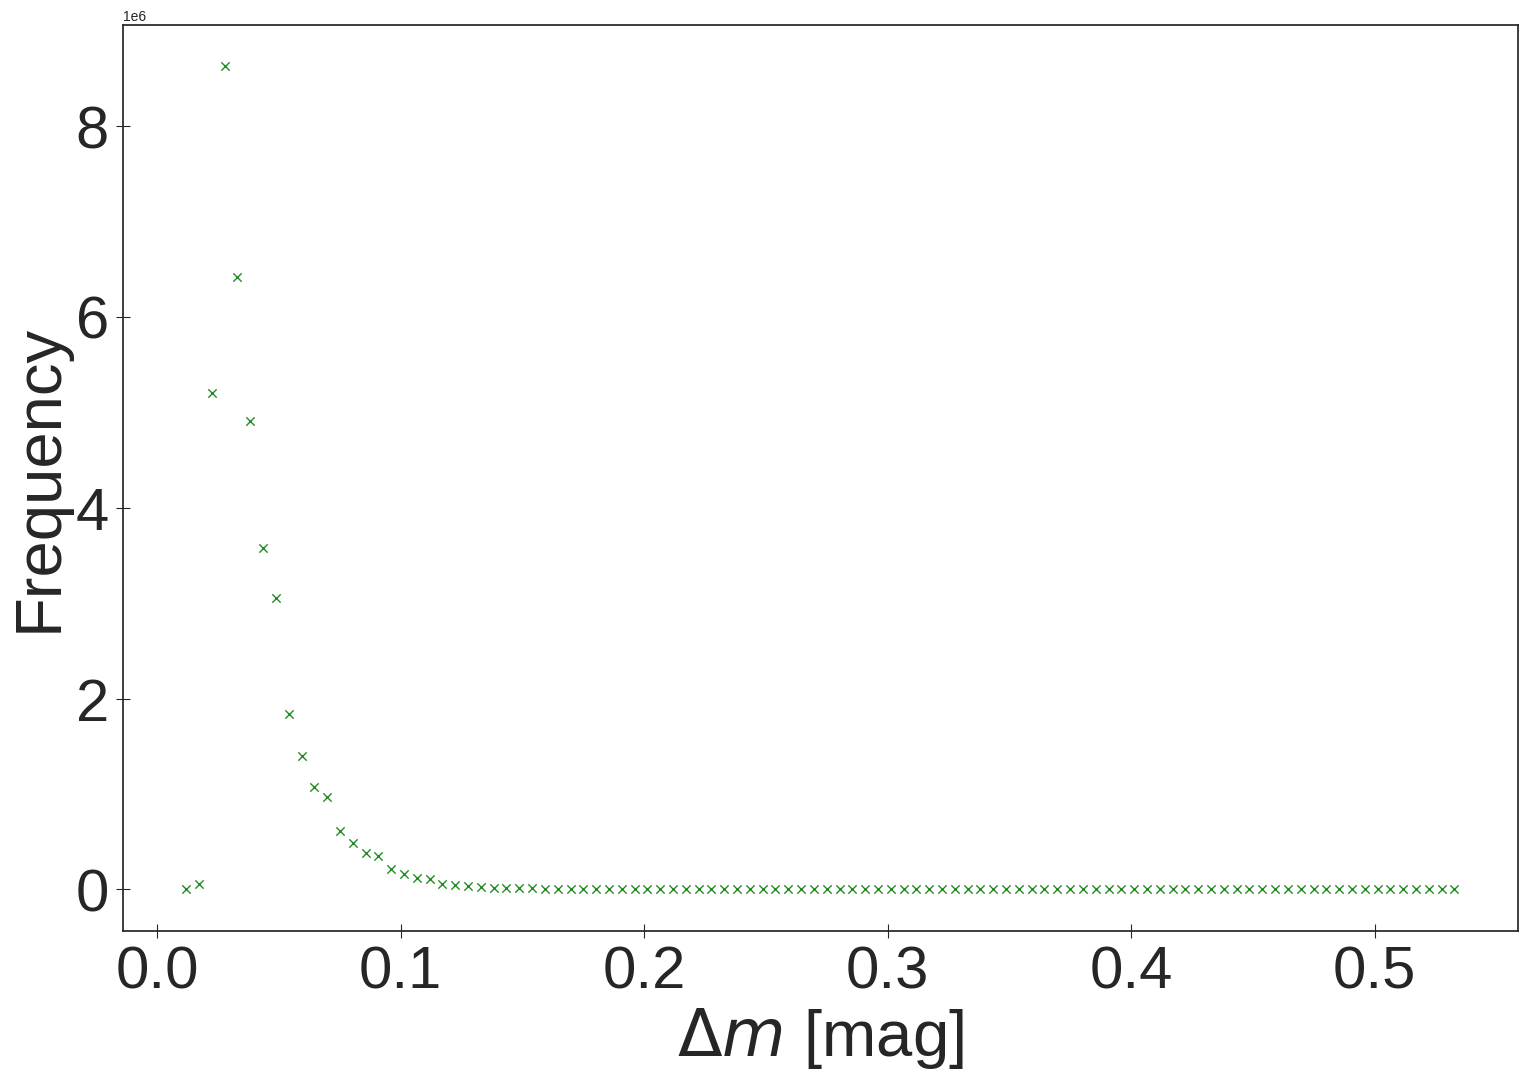

In [23]:
# form the figure:
hist_form()

# make and plot the histograms:
freq, bins = np.histogram( w1err_frame.w1mCorrErr, bins=100 )
plt.scatter( bins[:-1], freq,  marker = 'x', lw = 1, color = 'forestgreen' )

In [24]:
sm_tot = pd.read_csv( 'total_sm.txt', delimiter= '\t', low_memory = False )
print( """the columns of the dataframe of galaxies whose have stellar mass from
          at least one method:\n""", sm_tot.columns,
      '\n\nthe length of this dataframe:', len(sm_tot), '\n\nthe header:' )
sm_tot.head()

the columns of the dataframe of galaxies whose have stellar mass from
          at least one method:
 Index(['GWGC', 'Hyp', 'designation', 'wiseX', 'type', 'ra', 'dec', 'Kmag',
       'W1', 'W2', 'z', 'lumdis', 'lumdis_err', 'k_m_ext', 'k_msig_ext',
       'SMass_Cluver', 'SMass_Kettlety', 'SMass_Jarrett', 'SMass_Cappellari',
       'err_SMass_Kettlety', 'err_SMass_Cappellari'],
      dtype='object') 

the length of this dataframe: 21203660 

the header:


,GWGC,Hyp,designation,wiseX,type,ra,dec,Kmag,W1,W2,...,lumdis,lumdis_err,k_m_ext,k_msig_ext,SMass_Cluver,SMass_Kettlety,SMass_Jarrett,SMass_Cappellari,err_SMass_Kettlety,err_SMass_Cappellari
0,NaN,1102028,00005632-0205221,J000056.39-020523.3,G,0.234695,-2.089495,13.827,14.308,14.035,...,521.341075,NaN,13.633,0.172,2.535866e+10,4.925340e+10,1.429716e+10,2.780576e+11,3.943290e+09,-3.192582e+10
1,NaN,1112296,23591740-0142134,J235917.43-014213.2,G,359.822540,-1.703735,13.889,13.936,13.822,...,359.314386,NaN,13.724,0.191,3.568311e+10,3.583475e+10,2.109919e+10,1.117994e+11,2.868976e+09,-1.709662e+10
2,NaN,1113689,NaN,J000014.50-013858.7,G,0.060450,-1.649560,NaN,14.165,13.836,...,959.938689,NaN,NaN,NaN,7.135246e+10,1.556472e+11,3.987521e+10,NaN,1.246131e+10,NaN
3,NaN,NaN,23581606-0137396,J235816.01-013739.3,G,359.566925,-1.627676,13.638,13.896,13.485,...,976.885557,NaN,13.293,0.203,6.522868e+10,2.050275e+11,3.551412e+10,1.560942e+12,1.641477e+10,-1.737218e+11
4,NaN,1113236,23575503-0140058,J235755.05-014005.8,G,359.479309,-1.668278,14.267,13.922,13.722,...,788.222607,NaN,13.887,0.235,1.104303e+11,1.415380e+11,6.410814e+10,5.335825e+11,1.133172e+10,-8.859512e+10


In [25]:
len(w1err_frame), len(sm_tot)

(39816120, 21203660)

In [26]:
data_inner = pd.merge( sm_tot, w1err_frame, on=['wiseX'], how='inner' )
print( 'merged dataframe:\n' )
data_inner.head()

merged dataframe:



,GWGC,Hyp,designation,wiseX,type,ra,dec,Kmag,W1,W2,...,k_m_ext,k_msig_ext,SMass_Cluver,SMass_Kettlety,SMass_Jarrett,SMass_Cappellari,err_SMass_Kettlety,err_SMass_Cappellari,w1mCorr,w1mCorrErr
0,NaN,1102028,00005632-0205221,J000056.39-020523.3,G,0.234695,-2.089495,13.827,14.308,14.035,...,13.633,0.172,2.535866e+10,4.925340e+10,1.429716e+10,2.780576e+11,3.943290e+09,-3.192582e+10,14.308,0.056
1,NaN,1112296,23591740-0142134,J235917.43-014213.2,G,359.822540,-1.703735,13.889,13.936,13.822,...,13.724,0.191,3.568311e+10,3.583475e+10,2.109919e+10,1.117994e+11,2.868976e+09,-1.709662e+10,13.936,0.027
2,NaN,1113689,NaN,J000014.50-013858.7,G,0.060450,-1.649560,NaN,14.165,13.836,...,NaN,NaN,7.135246e+10,1.556472e+11,3.987521e+10,NaN,1.246131e+10,NaN,14.165,0.027
3,NaN,NaN,23581606-0137396,J235816.01-013739.3,G,359.566925,-1.627676,13.638,13.896,13.485,...,13.293,0.203,6.522868e+10,2.050275e+11,3.551412e+10,1.560942e+12,1.641477e+10,-1.737218e+11,13.896,0.027
4,NaN,1113236,23575503-0140058,J235755.05-014005.8,G,359.479309,-1.668278,14.267,13.922,13.722,...,13.887,0.235,1.104303e+11,1.415380e+11,6.410814e+10,5.335825e+11,1.133172e+10,-8.859512e+10,13.922,0.027


In [27]:
len(sm_tot[~np.isnan(sm_tot.W1)]) - len(data_inner)

2139

In [28]:
len(w1err_frame), len(sm_tot[~np.isnan(sm_tot.W1)])

(39816120, 20410315)

#### Checking the magnitudes

In [31]:
np.mean( data_inner.w1mCorrErr ), np.max( data_inner.w1mCorrErr ), np.min( data_inner.w1mCorrErr )

(0.04361852730008143, 0.509, 0.022000000000000002)

In [30]:
np.median( w1err_frame.w1mCorrErr)

0.038

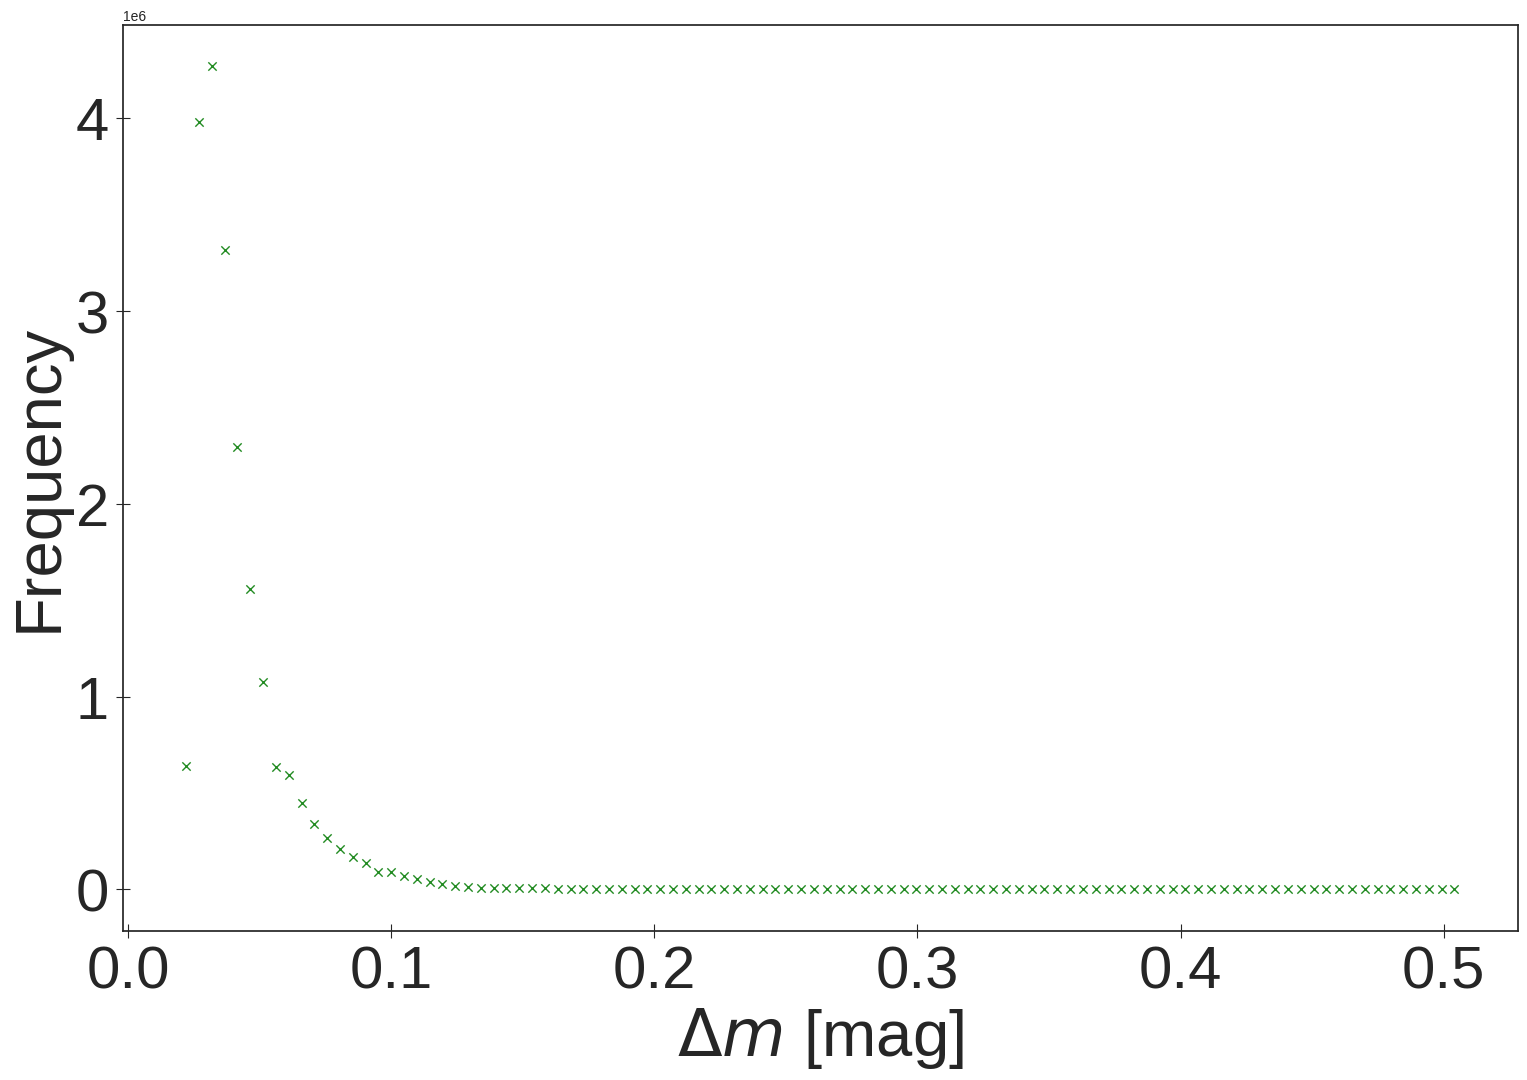

In [33]:
# form the figure:
hist_form()

# make and plot the histograms:
freq, bins = np.histogram( data_inner.w1mCorrErr, bins=100 )
plt.scatter( bins[:-1], freq,  marker = 'x', lw = 1, color = 'forestgreen' )

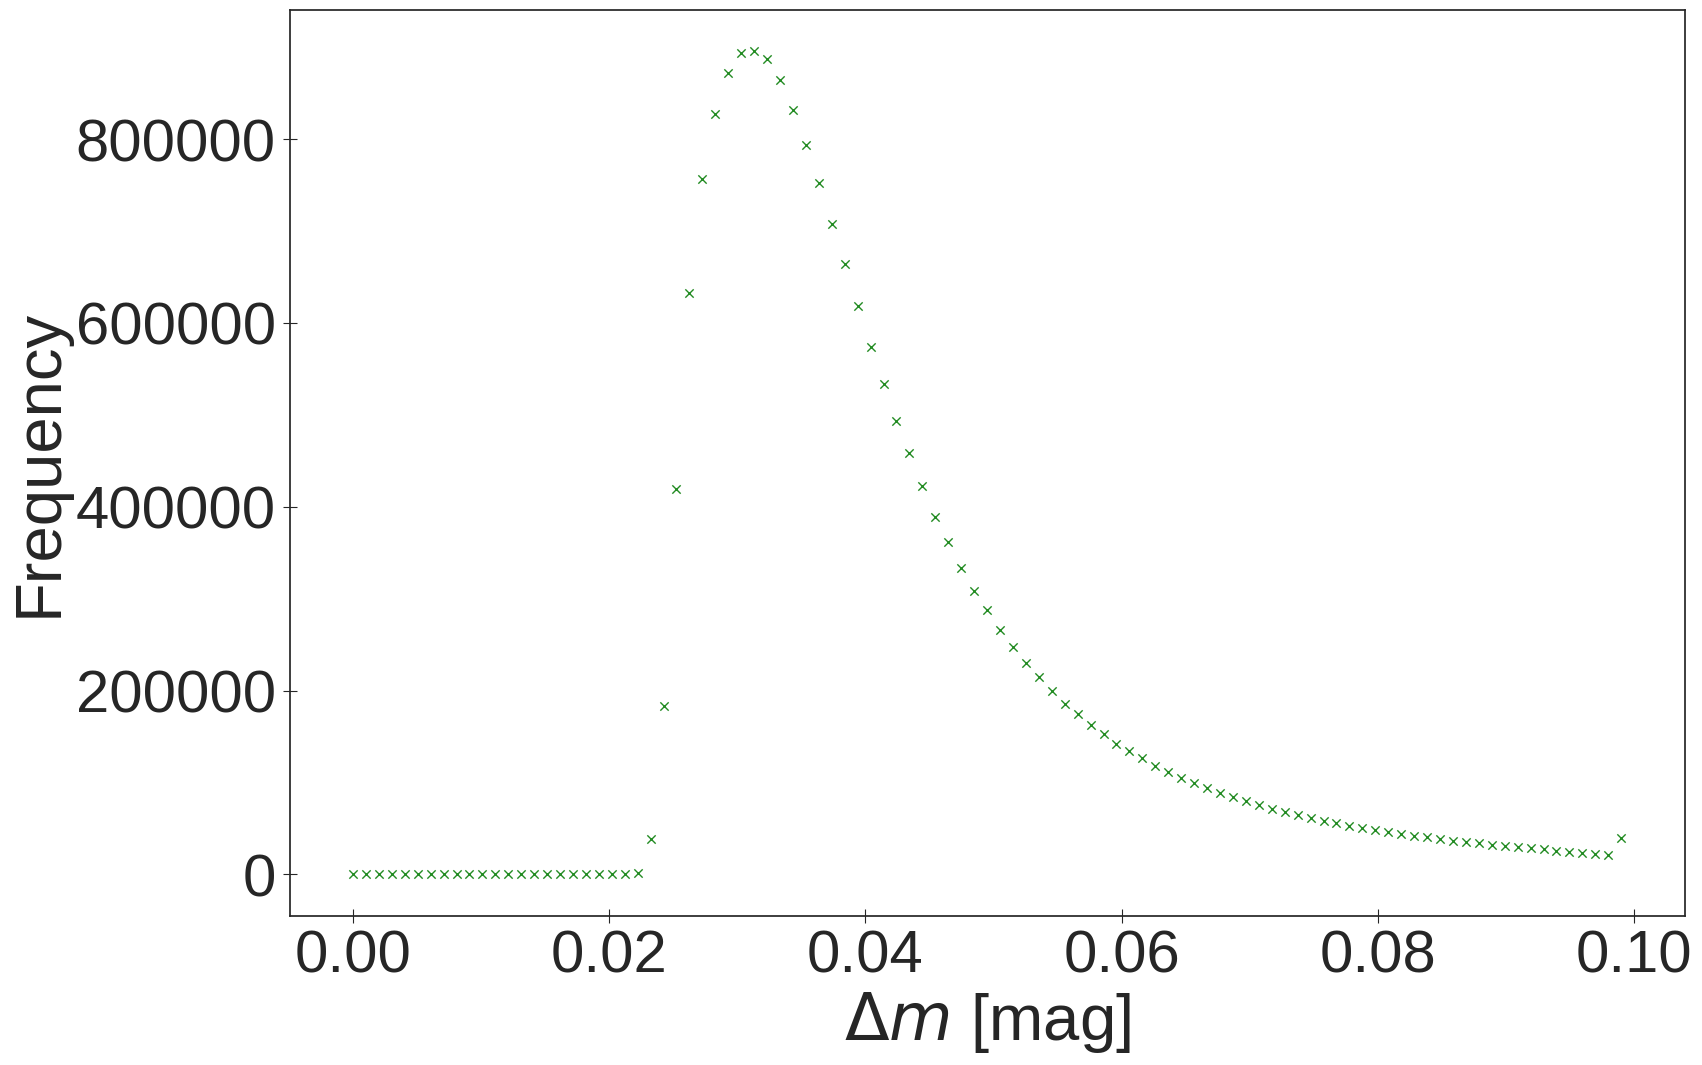

In [34]:
# form the figure:
hist_form()

# make and plot the histograms:
freq, bins = np.histogram( data_inner.w1mCorrErr, bins=np.linspace(0, 0.1, 100) )
plt.scatter( bins[:-1], freq,  marker = 'x', lw = 1, color = 'forestgreen' )